# PHASE 1:

DATA PREPROCESSING:


In [17]:
# Phase 1: Data Preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv("housing.csv")

# Handle missing values (use median for total_bedrooms)
imputer = SimpleImputer(strategy="median")
df["total_bedrooms"] = imputer.fit_transform(df[["total_bedrooms"]])

# One-hot encode 'ocean_proximity' with drop_first=True (drops '<1H_OCEAN')
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

# Final feature list for reference
print("Final Features After Encoding:\n", df.columns.tolist())

# Separate features and target
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Final Features After Encoding:
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


# PHASE 2:

Model Development (Linear Regression with Gradient Descent Variants)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_mse,▁
train_loss,█▇▆▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
test_mse,4898769205.07209
train_loss,4684929871.44628


Epoch 1, Train Loss: 6860635731.41
Epoch 2, Train Loss: 5085280002.00
Epoch 3, Train Loss: 4946386516.31
Epoch 4, Train Loss: 4892208422.68
Epoch 5, Train Loss: 4854937253.96
Epoch 6, Train Loss: 4827138428.25
Epoch 7, Train Loss: 4805734620.23
Epoch 8, Train Loss: 4788836820.15
Epoch 9, Train Loss: 4775204295.90
Epoch 10, Train Loss: 4764000171.84
Epoch 11, Train Loss: 4754647285.41
Epoch 12, Train Loss: 4746738374.65
Epoch 13, Train Loss: 4739979141.45
Epoch 14, Train Loss: 4734151759.72
Epoch 15, Train Loss: 4729091223.89
Epoch 16, Train Loss: 4724669817.56
Epoch 17, Train Loss: 4720786755.62
Epoch 18, Train Loss: 4717361152.60
Epoch 19, Train Loss: 4714327153.31
Epoch 20, Train Loss: 4711630487.88
Epoch 21, Train Loss: 4709225980.14
Epoch 22, Train Loss: 4707075705.37
Epoch 23, Train Loss: 4705147599.53
Epoch 24, Train Loss: 4703414388.80
Epoch 25, Train Loss: 4701852751.58
Epoch 26, Train Loss: 4700442652.69
Epoch 27, Train Loss: 4699166807.70
Epoch 28, Train Loss: 4698010247.54
E

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇███
test_mse,▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
test_mse,4898769205.07209
train_loss,4684929871.44628


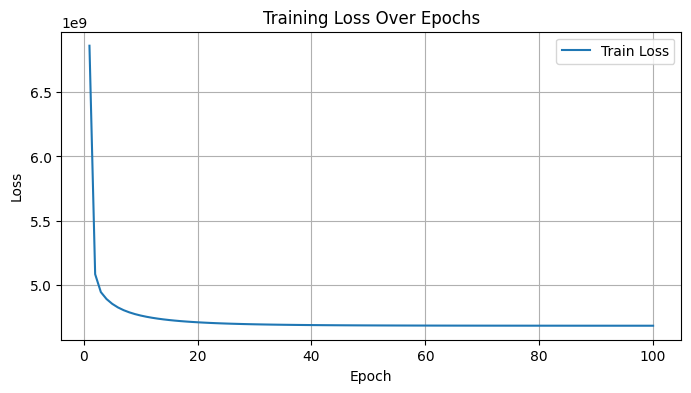

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize wandb run
wandb.init(
    project="california-housing-price",
    name="sgd-l1-manual-logging",
    config={
        "model": "SGDRegressor",
        "loss": "squared_error",
        "penalty": "l1",
        "learning_rate": "constant",
        "eta0": 0.0001,
        "early_stopping": True,
        "max_iter": 1000,
        "validation_fraction": 0.1,
        "random_state": 42,
        "test_size": 0.2,
        "epochs": 100
    }
)

# Load and preprocess data
df = pd.read_csv("housing.csv")

# Impute missing values
imputer = SimpleImputer(strategy="median")
df["total_bedrooms"] = imputer.fit_transform(df[["total_bedrooms"]])

# One-hot encoding
df = pd.get_dummies(df, columns=["ocean_proximity"])

# Save feature names
feature_names = df.drop("median_house_value", axis=1).columns.tolist()

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Initialize model
model = SGDRegressor(
    max_iter=1,  # We manually control epochs
    learning_rate='constant',
    eta0=0.0001,
    penalty='l1',
    warm_start=True,
    random_state=42
)

# Custom training loop with early stopping
epochs = 100
best_loss = float("inf")
patience = 10
patience_counter = 0

train_losses = []

for epoch in range(epochs):
    model.partial_fit(X_train, y_train)
    preds = model.predict(X_train)
    train_loss = mean_squared_error(y_train, preds)

    wandb.log({"epoch": epoch + 1, "train_loss": train_loss})
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.2f}")

    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluate on test set
y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
wandb.log({"test_mse": test_mse})

# Plot train loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.savefig("loss_curve.png")
wandb.log({"loss_curve": wandb.Image("loss_curve.png")})

# Save model, scaler, and features
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_names, "feature_names.pkl")

# Save model, scaler, and features
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_names, "feature_names.pkl")

wandb.finish()
